<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
<font color=#4d7db8>
Sharif University of Technology - Department of Electrical Engineering
</font>
<p></p>
<font color=#4d7db8>
Introduction To Machine Learning - Dr. Sajjad Amini
</font>
<br/>
<br/>
Spring Semester 1401-02

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Project - 3rd Phase
<br />
Image Super Resolution using Autoencoder
			</font>
    <br/>
<font size=4>
			<br/><br/>
Due on Tir 10th
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=green>
Should you have any questions concerning the project, please feel free to ask via Telegram.
     </font>
</font>
                <br/>
    </div>

# Personal Info
<hr/>
    <div class="column" align=center>
    <font size=4>
        <div class="column">
        <br />
            student_number = <font color='yellow'> 99102507 </font>
            <br />
            Name = <font color='yellow'> Amir Hossein  </font>
            <br />
            Last_Name = <font color='yellow'> Yari </font>
        </div>
        <div class="column">
        <br />
            student_number = <font color='yellow'> 99104232 </font>
            <br />
            Name = <font color='yellow'> Amir Hossein  </font>
            <br />
            Last_Name = <font color='yellow'> Moraveji </font>
        </div>
    </font>
    </div>


1. Download the "image super resolution (from unsplash)" dataset and split it's validation set to new validation set and test set.
2. Design and train an AutoEncoder using `PyTorch` (not `TensorFlow`) on the dataset to enhance the resolution of images from low resolution to high resolution.
3. plot learning curve and visualize low resolution images of test set, their corresponding high resolution images and their reconstructed versions side by side.

# Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import zipfile

# Load Dataset and Prepare It

<font color=red size=3> Please put "high res" and "low res" folders in a zipped file and put that in the same directory as this notebook so that the address of images are like this : "zipfile_name/high res/1.jpg".

In [2]:
# Loading the complete dataset
def read_zip(zip_filename):
    # Opening the zip file
    with zipfile.ZipFile(zip_filename, "r") as zfile:
        # Getting the list of filenames in the zip file
        list_of_filenames = zfile.namelist()
        high = []
        low_2 = []
        low_4 = []
        low_6 = []
        info = None
        for filename in list_of_filenames:
            # Checking if the file is an image or a csv file
            if filename.endswith(".jpg"):
                # Decoding the image data using cv2.imdecode
                img = plt.imread(filename)
                # Checking if the image belongs to "high res" or "low res" folder
                if "high res" in filename:
                    high.append(img)
                elif "low res" in filename:
                    # Checking resolution quality
                    if "_2" in filename:
                        low_2.append(img)
                    elif "_4" in filename:
                        low_4.append(img)
                    else :
                        low_6.append(img)
            elif filename.endswith(".csv"):
                info = pd.read_csv(filename)
        return high, low_2, low_4, low_6, info
    
zipfile_name = 'unsplash dataset.zip'
complete_dataset = {}
complete_dataset['high'] , complete_dataset['low_2'] , complete_dataset['low_4'] , complete_dataset['low_6'] , info = read_zip(zipfile_name)

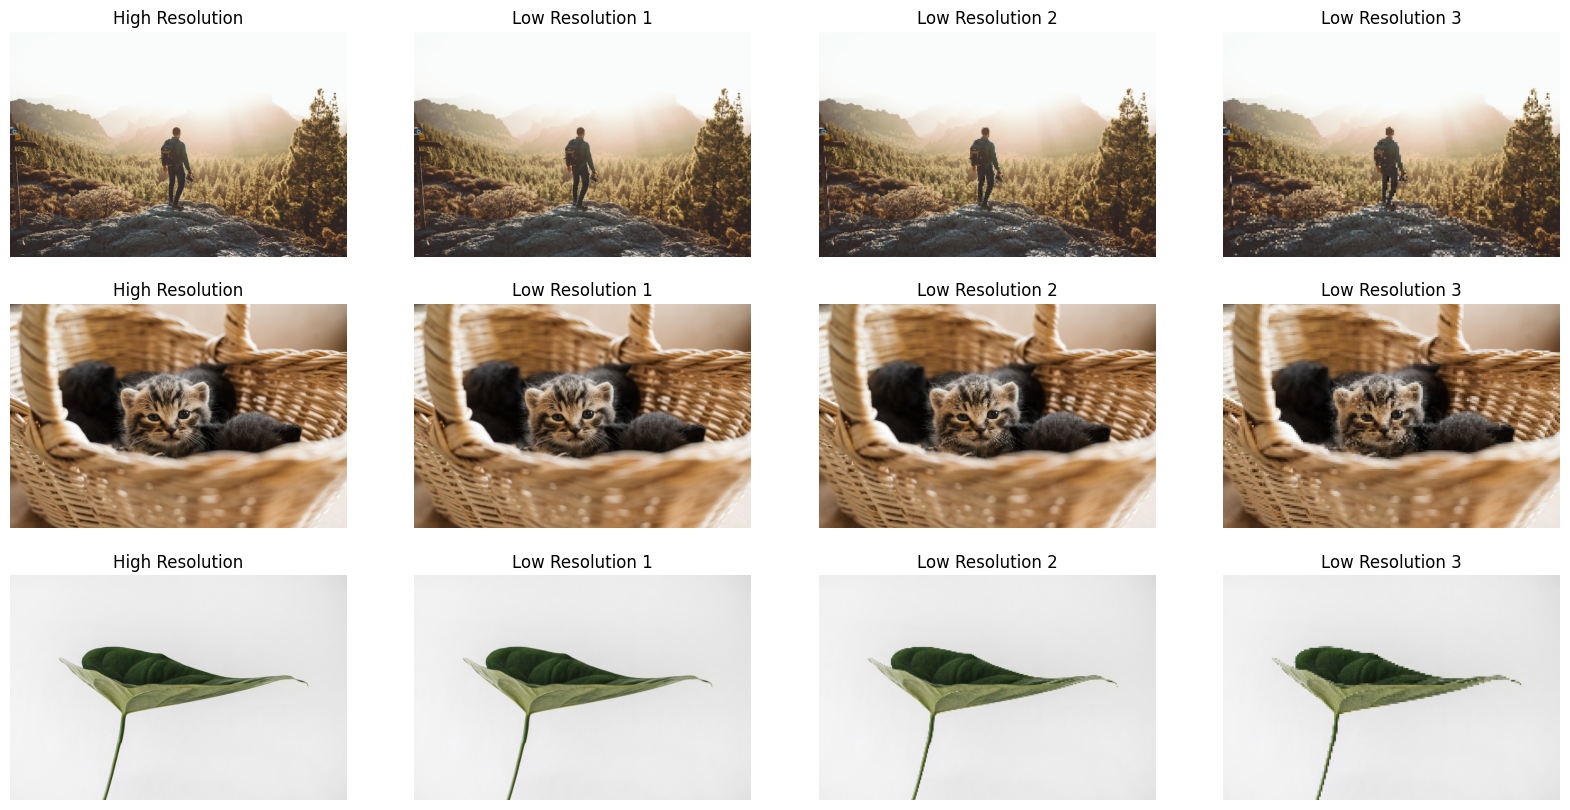

In [6]:
# We downloaded the dataset.
# It has 1 set of high resolution images and 3 sets of low resolution images with different degrees of resolution.
# Each set has 1254 images.

# Some examples :
r = np.random.randint(1,1254,(3,))
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(3,4,i*4+1)
    plt.imshow(complete_dataset['high'][r[i]-1])
    plt.title('High Resolution')
    plt.axis('off')
    plt.subplot(3,4,i*4+2)
    plt.imshow(complete_dataset['low_2'][r[i]-1])
    plt.title('Low Resolution 1')
    plt.axis('off')
    plt.subplot(3,4,i*4+3)
    plt.imshow(complete_dataset['low_4'][r[i]-1])
    plt.title('Low Resolution 2')
    plt.axis('off')
    plt.subplot(3,4,i*4+4)
    plt.imshow(complete_dataset['low_6'][r[i]-1])
    plt.title('Low Resolution 3')
    plt.axis('off')

In [104]:
# Use this code when dataset is in folders (not zipped file)

#class Dataset(torch.utils.data.Dataset):
#    def __init__(self,rd,img_numbers,img_size): # rd = resolution degree : 1,2 or 3
#        self.img_numbers = img_numbers
#        self.suff = '_'+str(2*rd)+'.jpg'
#        self.H = img_size[0]
#        self.W = img_size[1]
#    
#    def __len__(self):
#        return len(self.img_numbers)
#    
#    def __getitem__(self,idx):
#        high = torch.from_numpy((np.moveaxis(plt.imread('high res/'+str(self.img_numbers[idx])+'.jpg')[:self.H,:self.W,:],-1,0))/255).to(torch.float32)
#        low = torch.from_numpy((np.moveaxis(plt.imread('low res/'+str(self.img_numbers[idx])+self.suff)[:self.H,:self.W,:],-1,0))/255).to(torch.float32)
#        return (low , high)

# -----------------------------------------------------
# Use this code when dataset is in a zipped file

class Dataset(torch.utils.data.Dataset):
    def __init__(self, rd, img_numbers, img_size, complete_dataset): # rd = resolution degree : 1,2 or 3
        self.img_numbers = img_numbers
        self.low_name = 'low_'+str(2*rd)
        self.H = img_size[0]
        self.W = img_size[1]
    
    def __len__(self):
        return len(self.img_numbers)
    
    def __getitem__(self,idx):
        high = torch.from_numpy((np.moveaxis(complete_dataset['high'][idx][:self.H,:self.W,:],-1,0))/255).to(torch.float32)
        low = torch.from_numpy((np.moveaxis(complete_dataset[self.low_name][idx][:self.H,:self.W,:],-1,0))/255).to(torch.float32)
        return (low , high)

In [112]:
# Since the size of the data is too big for my computer to handle, i 
H = 797 # Choose the new size (input image will be cut)
W = 1196
rd = 3 # degree of resolution (1,2,3) for 1/2 , 1/4 , 1/6
batch_size = 4
N = 500 # total number of images

train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 0.1

train_size = int(train_ratio*N)
valid_size = int(valid_ratio*N)
test_size = N - train_size - valid_size

np.random.seed(10)
arr = np.arange(1,N,1)
np.random.shuffle(arr)
arr_train = arr[:train_size]
arr_valid = arr[train_size:train_size+valid_size]
arr_test = arr[train_size+valid_size:]

train_dataset = Dataset(rd=rd , img_numbers=arr_train , img_size=(H,W) , complete_dataset=complete_dataset)
valid_dataset = Dataset(rd=rd , img_numbers=arr_valid , img_size=(H,W) , complete_dataset=complete_dataset)
test_dataset = Dataset(rd=rd , img_numbers=arr_test , img_size=(H,W) , complete_dataset=complete_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Define Your Model
torch neural network model

In [118]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3,3,3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(3,3,3)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(3,3,3),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(3,3,3),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Fit The Model
Also Define optimizer, Criterion and other parameters 

In [119]:
# Model Initialization
model = AutoEncoder()
    
# Validation using MSE Loss function
criterion = torch.nn.MSELoss()
 
# Using an Adam Optimizer with learning rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)

epochs = 10
losses_train = epochs*[0]
losses_valid = epochs*[0]
for epoch in range(epochs):
    print(epoch)
    loss_per_epoch = 0
    
    for (low,high) in train_loader:
        # Output of Autoencoder
        reconstructed = model(low)
        
        # Calculating the loss function
        loss = criterion(reconstructed, high)*255
        
        # Updating weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Incrementing loss
        loss_per_epoch += loss.item()
    losses_train[epoch] = loss_per_epoch
    
    # Validation
    loss_per_epoch = 0
    
    for (low,high) in valid_loader:
        # Output of Autoencoder
        reconstructed = model(low)
        
        # Calculating the loss function
        loss = criterion(reconstructed, high)*255
        
        # Incrementing loss
        loss_per_epoch += loss.item()
    losses_valid[epoch] = loss_per_epoch

0
1
2
3
4
5
6
7
8
9


<font color='yellow'>
It should be noted that for a better understanding of the value of loss, its value is multiplied by 255 in order to have more sense of the numbers. So, to calculate the real losses, the values of the following chart should be divided by 255.
</font>

# Plot The Results

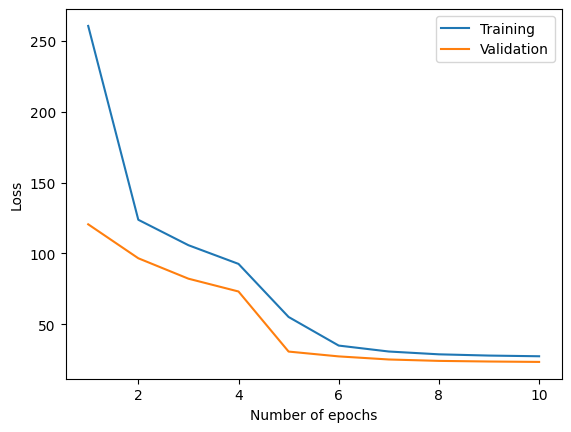

In [125]:
# Plotting the training loss
plt.plot(range(1,epochs+1),np.array(losses_train),label = 'Training')
plt.plot(range(1,epochs+1),losses_valid,label = 'Validation')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

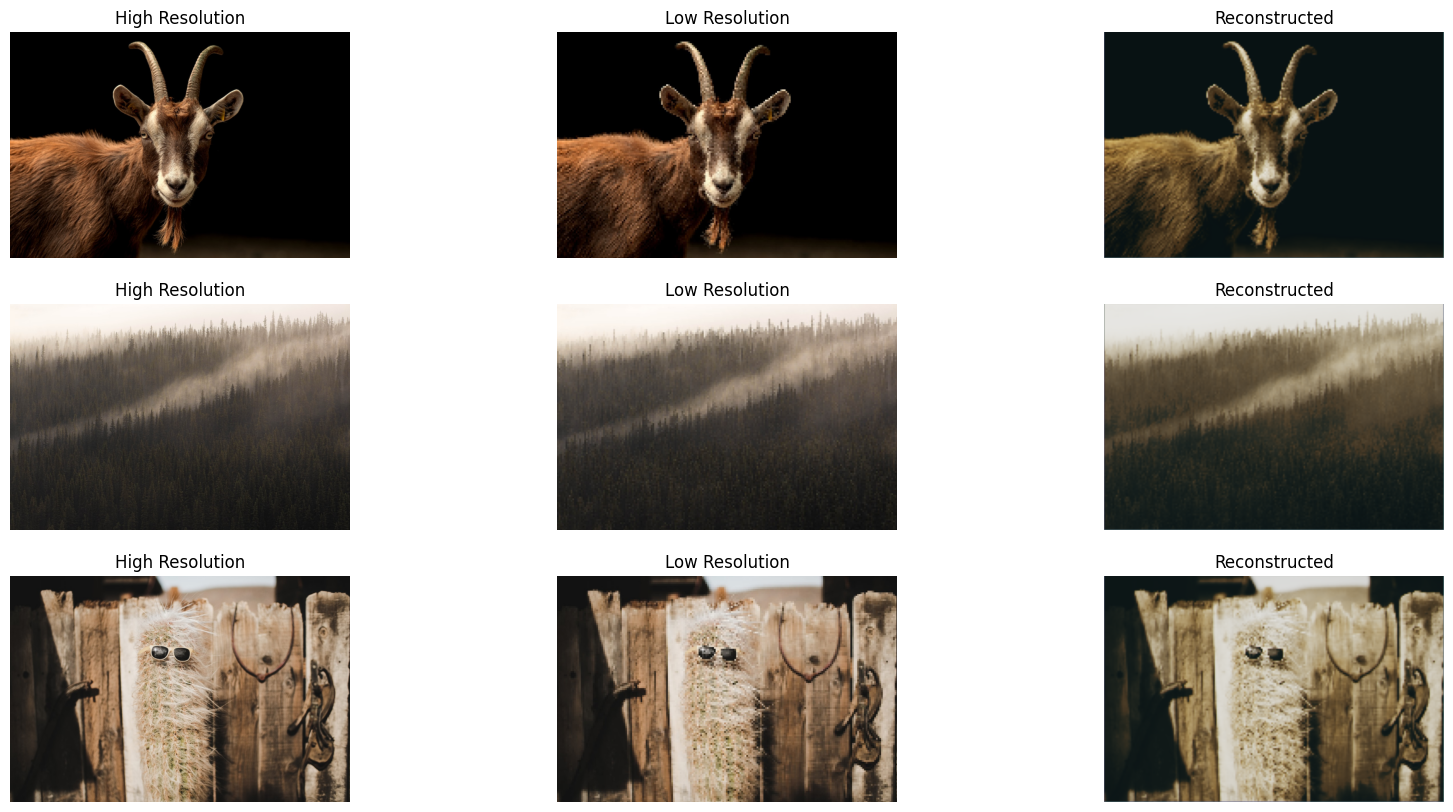

In [123]:
# plot some examples from test set
r = np.random.randint(0,test_size-1,(3,))
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(3,3,i*3+1)
    plt.imshow(complete_dataset['high'][arr_test[r[i]]-1][:H,:W,:])
    plt.title('High Resolution')
    plt.axis('off')
    plt.subplot(3,3,i*3+2)
    img = complete_dataset['low_'+str(2*rd)][arr_test[r[i]]-1][:H,:W,:]
    plt.imshow(img)
    plt.title('Low Resolution')
    plt.axis('off')
    plt.subplot(3,3,i*3+3)
    input_data = torch.from_numpy(np.moveaxis(img,-1,0)/255).to(torch.float32)
    output_data = model(input_data)
    recon = np.moveaxis(output_data.detach().numpy(),0,-1)
    plt.imshow(recon)
    plt.title('Reconstructed')
    plt.axis('off')

<font color='yellow'>
It should also be noted that due to the lack of time, the model was trained and tested on less than half of the images(500 images), and better results can be obtained by training on all the images. In the code of part 5, by changing N, you can train on the entire dataset and get better results.
</font>